### Building a sequence labeling model using PyTorch.

Author: Sameer Bansal

Date:   24-Nov-2018

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import seaborn

from sklearn.model_selection import train_test_split

from sklearn.metrics import precision_recall_fscore_support, accuracy_score
                                                                                                                                                                                                                                                                                                                    
from tqdm import tqdm

import math
import random
import os

from IPython.display import Image

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

/afs/inf.ed.ac.uk/group/project/lowres/work/miniconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence


## Sequence labeling model

We use a RNN based neural model to label a sequence of words.

For this task, we use a single model architecture to predict the following tag categories:
- POS
- Chunk
- NER

Using a neural model, allows us to conveniently switch between training for any of the 3 tasks.

The model we use is mainly adapted from the PyTorch tutorial:
- [PyTorch tutorial code for pos tagging](https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html#example-an-lstm-for-part-of-speech-tagging)

We modify the code to:
- Train in minibatches and on a GPU. This greatly speeds up training with models converging in **under 5 minutes of training time**.
- Increase modeling power by adding a two-layer LSTM, with a larger hidden layer size: 128.
- We use a bidirectional LSTM to better capture context.
- To prevent overfitting, we perform L2 regularization using a penalty = 0.0001


The model we use is a simplified version of the current state-of-the-art models:
 - [Barbara Plank and Zeljko Agic, Distant Supervision from Disparate Sources
for Low-Resource Part-of-Speech Tagging. In Proc. ACL '18.](http://aclweb.org/anthology/D18-1061) 


To train our models, we use the provided "ner_dataset.txt" file.

As this file has labels for POS, CHUNK, and NER tags, we train a model for each of these categories.


We also test our trained models using data from the following source:
- Using Validation and Test sets from: https://github.com/davidsbatista/NER-datasets/tree/master/CONLL2003


### Model architecture

The following image shows the neural model architecture.
In this example, we show the POS tags as the targets. 

We replace the targets with CHUNK, and NER tags to train all three models.

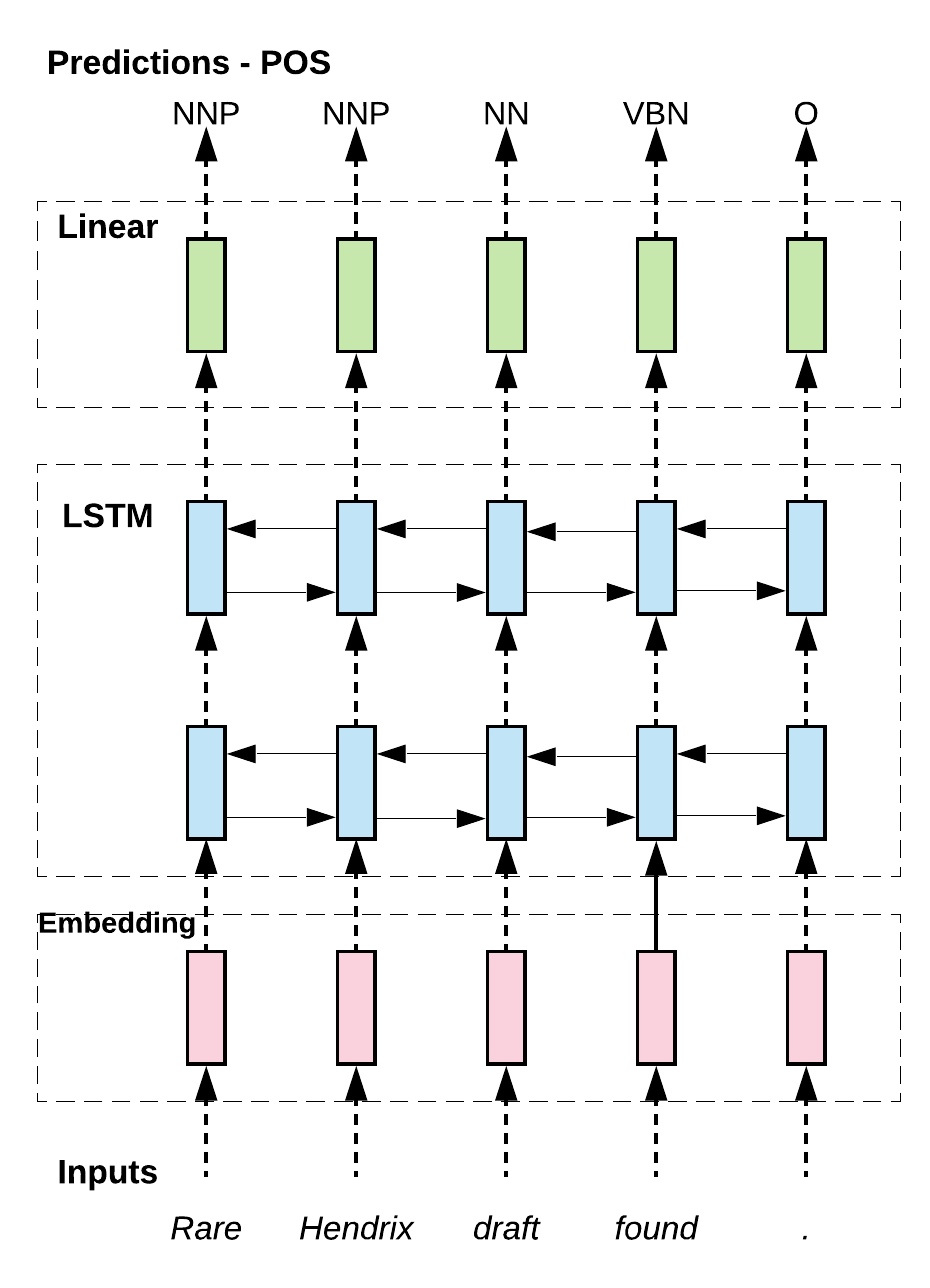

In [2]:
Image("./seq_label_model.png", width=350)

## Results

We have pre-trained all our models, and will first present the results.
For training details, refer to section: **Training and Validation**


Summary of results on test set:

|  Task |  Accuracy (%) |
|:-----:|---------------|
| POS   |  89.23        |
| CHUNK |  89.52        |
| NER   |  93.92        |



# NOTE!
**To execute the notebook**, execute all cells starting from Training and Validation till the end of the notebook.
Followed by the Results section

### Load pre-trained models

In [30]:
model ={}
for label in ["pos", "chunk", "ner"]:
    model[label] = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, 
                              len(to_ix["word"]), len(to_ix[label]))
    model[label].load_state_dict(torch.load("./models/{0:s}.model".format(label)))
    model[label].to(device)

## Make predictions on test set

Using "test.txt" from https://github.com/davidsbatista/NER-datasets/tree/master/CONLL2003

### POS tagging results

In [37]:
predict_on_test_set("./test.txt", "pos")

  1%|▏         | 23/1626 [00:00<00:06, 229.98it/s]

total lines=1626
computing dev set metrics


100%|██████████| 1626/1626 [00:05<00:00, 288.30it/s]

Final dev accuracy=89.23%
------------------------------------------------------------
Results for pos
------------------------------------------------------------
  label    | precision   |   recall    |   fscore    | total
------------------------------------------------------------
   NNP     |         82% |         91% |         86% |  8595
   VBZ     |         91% |         80% |         85% |   502
    JJ     |         72% |         75% |         73% |  2393
    NN     |         87% |         86% |         87% |  4931
    TO     |        100% |        100% |        100% |   818
    VB     |         82% |         90% |         86% |   933
    .      |        100% |        100% |        100% |  1630
    CD     |         99% |         79% |         88% |  5962
    DT     |         99% |         99% |         99% |  2799
   VBD     |         89% |         91% |         90% |  1699
    IN     |         99% |         97% |         98% |  4018
   PRP     |         99% |         98% |   

### CHUNK tagging results

In [38]:
predict_on_test_set("./test.txt", "chunk")

  1%|▏         | 24/1626 [00:00<00:06, 233.68it/s]

total lines=1626
computing dev set metrics


100%|██████████| 1626/1626 [00:05<00:00, 276.69it/s]


Final dev accuracy=89.52%
------------------------------------------------------------
Results for chunk
------------------------------------------------------------
  label    | precision   |   recall    |   fscore    | total
------------------------------------------------------------
   B-NP    |         84% |         92% |         88% | 12985
   B-VP    |         93% |         82% |         87% |  3767
   I-NP    |         91% |         88% |         90% | 16177
   I-VP    |         94% |         77% |         85% |  1913
    O      |         95% |         98% |         97% |  6210
   B-PP    |         92% |         98% |         95% |  3979
  B-SBAR   |         84% |         78% |         81% |   296
  B-ADJP   |         70% |         38% |         49% |   276
  I-ADJP   |         60% |         27% |         37% |    55
  B-ADVP   |         75% |         67% |         70% |   559
  B-PRT    |         85% |         48% |         62% |   110
 B-CONJP   |          0% |          0% | 

### NER tagging results

In [39]:
predict_on_test_set("./test.txt", "ner")

total lines=1626


  1%|▏         | 24/1626 [00:00<00:06, 233.68it/s]

computing dev set metrics


100%|██████████| 1626/1626 [00:06<00:00, 270.61it/s]

Final dev accuracy=93.92%
------------------------------------------------------------
Results for ner
------------------------------------------------------------
  label    | precision   |   recall    |   fscore    | total
------------------------------------------------------------
  B-ORG    |         87% |         56% |         68% |  1661
    O      |         97% |         98% |         98% | 38323
  B-MISC   |         68% |         75% |         72% |   702
  B-PER    |         82% |         79% |         81% |  1617
  I-PER    |         82% |         85% |         84% |  1156
  B-LOC    |         82% |         81% |         81% |  1668
  I-ORG    |         88% |         60% |         72% |   835
  I-MISC   |         40% |         65% |         50% |   216
  I-LOC    |         73% |         60% |         66% |   257
------------------------------------------------------------
Overall accuracy = 93.92%


### Predicting on texts

Read in validation and test sets for making predictions

In [40]:
_, dev_sentences = read_ner_file("./valid.txt")

total lines=1874


In [41]:
_, test_sentences = read_ner_file("./test.txt")

total lines=1626


Select 10 examples at random, and form sentences for each

In [42]:
sample_dev_texts = [" ".join(data[0]) for data in random.sample(dev_sentences, 10)]

In [43]:
sample_dev_texts[2]

'YEREVAN 1996-08-31 Armenia and Portugal drew 0-0 in a World Cup soccer European group 9 qualifier on Saturday .'

In [44]:
predict_on_texts(sample_dev_texts, tag="ner")[2]

[('YEREVAN', 'B-LOC'),
 ('1996-08-31', 'O'),
 ('Armenia', 'B-LOC'),
 ('and', 'O'),
 ('Portugal', 'B-LOC'),
 ('drew', 'O'),
 ('0-0', 'O'),
 ('in', 'O'),
 ('a', 'O'),
 ('World', 'B-MISC'),
 ('Cup', 'I-MISC'),
 ('soccer', 'O'),
 ('European', 'B-MISC'),
 ('group', 'O'),
 ('9', 'O'),
 ('qualifier', 'O'),
 ('on', 'O'),
 ('Saturday', 'O'),
 ('.', 'O')]

### Future work

**Note** *For the following sections, we include at most one or two relevant references. There are lots of good ideas being published, and we would like to cite more of them. However, to keep this discussion brief, we only point out the most relevant references here. We encourage people to check out related papers on Google Scholar, or your favorite research search engine.*


#### 1. Using pre-trained word embeddings

Recent work [1] has shown that pre-trained embeddings can vastly improve text classification performance. The neural model presented here can be easily adapted to make use of this method.

<img src="model_embeddings.png" alt="pre-trained embeddings" width="400"/>

We can use pre-trained word embeddings such as provided here:
1. [FastText](https://fasttext.cc/docs/en/english-vectors.html)
2. [ELMO](https://allennlp.org/elmo)

**Why?**

For these tagging tasks, we have about 10K sentences of labeled data. The number of English word types in the data are around 30K. This is a tiny fraction of the data being generated every day from mediums such as news outlets, financial reports, etc.

Pre-trained word embeddings are trained on billions of lines of text. The embeddings can better capture relationships between word types. Using external resources to boost the performance under limited training data settings makes a lot of sense.

References: 

[1] Howard, Jeremy, and Sebastian Ruder. "Universal language model fine-tuning for text classification." In Proc. ACL, 2018.

#### 2. Using character-level embeddings

A limitation of our model using words as input is that we won't be able to make predictions for any new words, not seen in the training set.

This can severely limit the utility of our model on real world data.

To overcome this, we recommend using character or subword level modeling instead [2]. Sennrich et al. show how subword modeling using *Byte-Pair Encoding* (BPE) can improve prediction of sequence models for unseen words.


<img src="./char_embeddings.png" alt="char embeddings" width="500"/>

References: 

References:
[2] Sennrich, Rico, Barry Haddow, and Alexandra Birch. "Neural Machine Translation of Rare Words with Subword Units." In Proc. ACL, 2016.

#### 3. Multi-task learning to model POS, CHUNK, and NER together

We currently train separate models for POS, chunk and NER labeling. Instead we can use multi-task learning to model all 3 tasks together.

We show our model modified to predict both POS, and NER tags, with the LSTM, and embedding layers being shared. This can be extended to include other related tasks as well.

<img src="./multitask_model.png" alt="char embeddings" width="600"/>

**Why?**

Previous work [3] has shown that modeling multiple related tasks together can help learn better representations in the lower layers, and lets models generalize across tasks. This also allows us to augment training data from other related tasks.

References:

[3] Liu, Pengfei, Xipeng Qiu, and Xuanjing Huang. "Recurrent neural network for text classification with multi-task learning." arXiv preprint arXiv:1605.05101 (2016).

### Model training trends

The following plot shows the model training trends. We periodically compute the accuracy on the dev set, to determine when to stop training.

We only show the plot for NER tagging and observe that the model converges within 10 epochs.

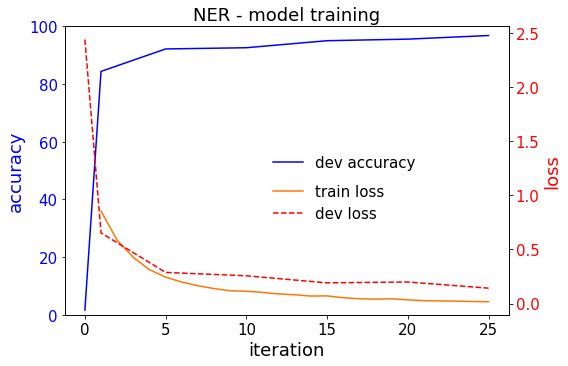

In [46]:
log_train = np.loadtxt('./models/ner.train', delimiter=',', skiprows=False).transpose()
log_test = np.loadtxt('./models/ner.dev', delimiter=',', skiprows=False).transpose()

fig, ax1 = plt.subplots(figsize=(8,5))
# fig, ax = plt.subplots(figsize=(8,5),nrows=1, ncols=1, sharey=True)
ax1.plot(log_test[0], log_test[2], 'b-', label="dev accuracy")
ax1.set_xlabel('iteration', size=18)
ax1.set_ylabel('accuracy', size=18, color='b')
ax1.set_ylim(0, 100)
for tl in ax1.get_yticklabels():
    tl.set_color('b')
    tl.set_fontsize(15)
plt.legend(bbox_to_anchor=(0.82, 0.6), framealpha=0, fontsize=15)
ax2 = ax1.twinx()
ax2.plot(log_train[0], log_train[1], color='#ff7700', label="train loss")
ax2.plot(log_test[0], log_test[1], 'r--', label="dev loss")
ax2.set_ylabel('loss', size=18, color='r')
for tl in ax2.get_yticklabels():
    tl.set_color('r')
    tl.set_fontsize(15)
for tl in ax1.get_xticklabels():
    tl.set_fontsize(15)
plt.legend(bbox_to_anchor=(0.75, 0.5), framealpha=0, fontsize=15)
plt.tight_layout()
plt.title("NER - model training", fontsize=18)
plt.show()

# To execute notebook - START HERE

## Training and Validation

### Read dataset

In [3]:
"""
Function to read the dataset and extract all 4 categories.
We use an RNN model to capture context, and this requires a sequence of words as input.
To create this sequence, we group a set of words and their corresponding tags together
until the end-of-line " . " is encountered.

For example, the following lines of input:
    EU NNP B-NP B-ORG
    rejects VBZ B-VP O
    German JJ B-NP B-MISC
    call NN I-NP O
    to TO B-VP O
    boycott VB I-VP O
    British JJ B-NP B-MISC
    lamb NN I-NP O
    . . O O
    Only RB B-NP O
    France NNP I-NP B-LOC
    and CC I-NP O
    Britain NNP I-NP B-LOC
    backed VBD B-VP O
    Fischler NNP B-NP B-PER
    's POS B-NP O
    proposal NN I-NP O
    . . O O

are parsed out as two sequences:

    [('EU', 'NNP', 'B-NP', 'B-ORG'),
     ('rejects', 'VBZ', 'B-VP', 'O'),
     ('German', 'JJ', 'B-NP', 'B-MISC'),
     ('call', 'NN', 'I-NP', 'O'),
     ('to', 'TO', 'B-VP', 'O'),
     ('boycott', 'VB', 'I-VP', 'O'),
     ('British', 'JJ', 'B-NP', 'B-MISC'),
     ('lamb', 'NN', 'I-NP', 'O'),
     ('.', '.', 'O', 'O')],
     
 and
     [('Only', 'RB', 'B-NP', 'O'),
     ('France', 'NNP', 'I-NP', 'B-LOC'),
     ('and', 'CC', 'I-NP', 'O'),
     ('Britain', 'NNP', 'I-NP', 'B-LOC'),
     ('backed', 'VBD', 'B-VP', 'O'),
     ('Fischler', 'NNP', 'B-NP', 'B-PER'),
     ("'s", 'POS', 'B-NP', 'O'),
     ('proposal', 'NN', 'I-NP', 'O'),
     ('.', '.', 'O', 'O')]
"""
def read_ner_file(filepath):
    ner_df_tuples = []
    with open(filepath, "r", encoding="utf-8") as in_f:
        lines = []
        count = 0
        curr_line = ([],[],[],[])
        for line in in_f:
            line_items = line.split()
            if len(line_items) != 4 or line_items[0] == "-DOCSTART-":
                continue
            
            for idx, item in enumerate(line_items):
                curr_line[idx].append(item)

            if line_items[0] == ".":
                lines.append(tuple(map(tuple, curr_line)))
                curr_line = curr_line = ([],[],[],[])
            # end if
            ner_df_tuples.append(line_items)
        # end for lines
    print("total lines={0:d}".format(len(lines)))
    ner_df = pd.DataFrame(ner_df_tuples, columns=["word", "pos", "chunk", "ner"])
    return ner_df, lines

In [4]:
"""
Input is a list of sentences:
Input: 
['ROMANIA COMELF H1 PROFIT RISE BELOW TARGET .',
'From January to June Comelf exported 59 percent of its output , up from 37.3 percent in the same period last year .']

Output: list of words in each sentence with the predicted tag:

[[('ROMANIA', 'B-LOC'),
  ('COMELF', 'B-ORG'),
  ('H1', 'O'),
  ('PROFIT', 'O'),
  ('RISE', 'O'),
  ('BELOW', 'O'),
  ('TARGET', 'O'),
  ('.', 'O')],
  
  [('From', 'O'),
  ('January', 'O'),
  ('to', 'O'),
  ('June', 'O'),
  ('Comelf', 'B-ORG'),
  ('exported', 'O'),
  ('59', 'O'),
  ('percent', 'O'),
  ('of', 'O'),
  ('its', 'O'),
  ('output', 'O'),
  (',', 'O'),
  ('up', 'O'),
  ('from', 'O'),
  ('37.3', 'O'),
  ('percent', 'O'),
  ('in', 'O'),
  ('the', 'O'),
  ('same', 'O'),
  ('period', 'O'),
  ('last', 'O'),
  ('year', 'O'),
  ('.', 'O')]],
"""
def predict_on_texts(texts, tag="ner"):
    predictions = []
    for text in texts:
        words = text.strip().split()        
        preds = get_sentence_predictions(words, model[tag], tag)
        predictions.append(list(zip(words, preds)))
    return predictions

In [36]:
"""
Read a file in the same format as the training data:
    word -- pos -- chunk -- ner
    
tag: specifies which model to use

Output:
Computes overall accuracy and tag level metrics
"""
def predict_on_test_set(filepath, tag="ner"):
    _, test_sentences = read_ner_file(filepath)
    print("computing dev set metrics")
    y_preds, y_true, correct, total = eval_set_no_loss(test_sentences, 
                                                         tag,
                                                         model[tag],
                                                         display=True)
    test_accuracy = correct/total*100
    print("Final dev accuracy={0:.2f}%".format(test_accuracy))
    display_eval(y_true, y_preds, tag)

After parsing the input, we get a total of **9K** sentences.

In [6]:
ner_df, ner_lines = read_ner_file("./ner_dataset.txt")

total lines=9248


In [7]:
ner_df.head(10)

,word,pos,chunk,ner
0,EU,NNP,B-NP,B-ORG
1,rejects,VBZ,B-VP,O
2,German,JJ,B-NP,B-MISC
3,call,NN,I-NP,O
4,to,TO,B-VP,O
5,boycott,VB,I-VP,O
6,British,JJ,B-NP,B-MISC
7,lamb,NN,I-NP,O
8,.,.,O,O
9,Peter,NNP,B-NP,B-PER


Unique values in each column constitute their vocabulary size.

In [8]:
ner_df.describe()

,word,pos,chunk,ner
count,254983,254983,254983,254983
unique,26883,45,21,9
top,.,NNP,I-NP,O
freq,9248,42950,82998,212337


The most frequent POS and NER tags in the dataset.

**NNP** is the most common POS tag, with 43K tokens out of a total 250K.

**O** is the most common NER tag with almost 200K out of 250K tokens.

This is expected as we named entities don't occur very often.

In [9]:
print(ner_df.pos.value_counts()[:5])
print(ner_df.ner.value_counts()[:5])

NNP    42950
NN     29925
IN     24041
CD     24000
DT     16974
Name: pos, dtype: int64
O        212337
B-LOC      8977
B-PER      8442
B-ORG      7662
I-PER      5835
Name: ner, dtype: int64


Example of our parsed dataset entry. Here we group the tags together, but they are
stored as individual lists

In [10]:
list(zip(*ner_lines[10]))

[('Only', 'RB', 'B-NP', 'O'),
 ('France', 'NNP', 'I-NP', 'B-LOC'),
 ('and', 'CC', 'I-NP', 'O'),
 ('Britain', 'NNP', 'I-NP', 'B-LOC'),
 ('backed', 'VBD', 'B-VP', 'O'),
 ('Fischler', 'NNP', 'B-NP', 'B-PER'),
 ("'s", 'POS', 'B-NP', 'O'),
 ('proposal', 'NN', 'I-NP', 'O'),
 ('.', '.', 'O', 'O')]

As we will be using a sequence model, it is important to check the maximum length of sentences
in the training data.

Very long sequences, > 100, can affect the model performance.

For training, we truncate sentences longer than 150 words.

In [11]:
"""
Longest sequence in the dataset
"""
MAX_LEN = min(np.max([len(line[0]) for line in ner_lines]), 150)
print(MAX_LEN)
print(np.mean([len(line[0]) for line in ner_lines]))

150
27.57125865051903


Truncating sentences should be ok as >90 % of the dataset fits within 150 words.

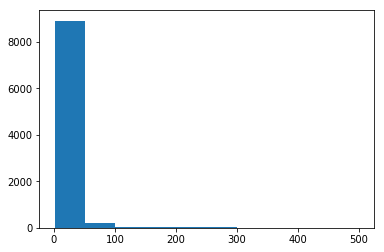

In [12]:
_ = plt.hist([min(len(line[0]),500) for line in ner_lines])

### Create Train/Validation splits

We constrain all our training and tuning of hyper-parameters to the dataset provided:
"ner_dataset.txt"

To check if our model is generalizing, we carve out 10% of the training set, and use it only for validation.

In [13]:
random.seed("hmm")
training_data, dev_data = train_test_split(ner_lines, test_size=0.1, random_state=1)

In [14]:
len(training_data), len(dev_data)

(8323, 925)

We shuffle the data prior to training, as we don't want the data order to impact model performance.

In [15]:
np.random.shuffle(training_data)

### Build index mappings

To train models, we replace the words in the dataset, with unique integer mappings.

We add an "\_UNK" tag id. This will be used to represent any words in a validation/test set which
do not occur in the training set

In [16]:
def build_vocab(data_series):
    w2ix = {"_PAD":0, "_UNK":1}
    for w in data_series:
        if w not in w2ix:
            w2ix[w] = len(w2ix)
        # end if
    # end for
    ixtow = {i: w for w, i in w2ix.items()}
    return w2ix, ixtow

In [17]:
# order of data in input file
DATA_LABELS = {"word":0, "pos":1, "chunk":2, "ner":3}
# build vocabulary for
to_ix = {}
to_label = {}
for k in DATA_LABELS:
    to_ix[k] = {}
    to_label[k] = {}
    to_ix[k], to_label[k] = build_vocab(ner_df[k])

In [18]:
for k in DATA_LABELS:
    print(k, len(to_ix[k]), len(to_label[k]))

word 26885 26885
pos 47 47
chunk 23 23
ner 11 11


In [19]:
to_ix["ner"]

{'_PAD': 0,
 '_UNK': 1,
 'B-ORG': 2,
 'O': 3,
 'B-MISC': 4,
 'B-PER': 5,
 'I-PER': 6,
 'B-LOC': 7,
 'I-ORG': 8,
 'I-MISC': 9,
 'I-LOC': 10}

## Neural model

We now define the neural model class and supporting functions for training, making predictions and evaluation


In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
torch.manual_seed(1)

## Use GPUs if available

In [21]:
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

## Model hyperparameters

In [22]:
EMBEDDING_DIM = 128
# We use a bi-directional LSTM, hidden dim size is for each direction
HIDDEN_DIM = 64
BATCH_SIZE = 64
NUM_LSTM_LAYERS=2

### Model

- Two layer bi-directional LSTM

In [23]:
class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim
        
        # define an embedding layer
        # currently we use words
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # the embeddings feed into a bi-directional LSTM layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=NUM_LSTM_LAYERS, bidirectional=True)

        # the LSTM layer feeds into a linear layer which generates
        # scores for over the target classes
        self.hidden2tag = nn.Linear(hidden_dim*2, tagset_size)
        
        # Pytorch code for default hidden states
        self.hidden = self.init_hidden(batch_size=1)

    def init_hidden(self, batch_size):
        # Before we've done anything, we dont have any hidden state.
        # Refer to the Pytorch documentation to see exactly
        # why they have this dimensionality.
        # The axes semantics are (num_layers, minibatch_size, hidden_dim)
        return (torch.zeros(NUM_LSTM_LAYERS*2, batch_size, self.hidden_dim).to(device),
                torch.zeros(NUM_LSTM_LAYERS*2, batch_size, self.hidden_dim).to(device))

    def forward(self, batch_data):
        # get embeddings for every word
        embeds = self.word_embeddings(batch_data)
        # get hidden states with context using LSTM
        lstm_out, self.hidden = self.lstm(embeds, self.hidden)
        # get scores for each class
        tag_space = self.hidden2tag(lstm_out)
        # convert raw scores into log softmax
        tag_scores = F.log_softmax(tag_space, dim=-1)
        return tag_scores

### Helper functions

In [24]:
def prepare_sequence(seq, to_ix, max_len):
    # Check if in vocab, else return UNK
    # Use UNK = 1 if word not in vocab
    #idxs = [to_ix.get(w, "UNK") for w in seq[:max_len]]
    idxs = [to_ix.get(w, 1) for w in seq[:max_len]]
    return torch.tensor(idxs, dtype=torch.long).to(device)

In [25]:
def prepare_batch(seqs, to_ix, max_len):
    batch_data = pad_sequence([prepare_sequence(seq, to_ix, max_len) 
                                                for seq in seqs]).to(device)
    return batch_data
    

In [26]:
def sentence_scores(sentence, model):
    sentence_in = prepare_batch([sentence], to_ix["word"], len(sentence))
    model.hidden = model.init_hidden(sentence_in.shape[1])
    tag_scores = model(sentence_in)
    return tag_scores

In [27]:
def get_sentence_predictions(sentence, model, tag):
    predicted_labels = []
    with torch.no_grad():
        tag_scores = sentence_scores(sentence, model)
        _, preds = torch.max(tag_scores.squeeze(1), 1)
        
        predicted_labels = [to_label[tag][i.item()] for i in preds]
        
    return predicted_labels

In [33]:
def eval_set_no_loss(eval_data, tag, model, display=True):
    # make predictions on a 
    # count the number of correct predictions and the total targets
    correct = 0
    total_tags = 0
    # track loss
    loss = 0

    predicted_labels = []
    ground_truth = []

    with torch.no_grad():
        for idx in tqdm(range(0, len(eval_data), 1), disable=not display):
            sentence_in = eval_data[idx][0]
            target_tags = [eval_data[idx][DATA_LABELS[tag]]]
            
            tag_scores = sentence_scores(sentence_in, model)
            targets = prepare_batch(target_tags, to_ix[tag], len(target_tags[0]))

            _, preds = torch.max(tag_scores.squeeze(1), 1)
            correct += (preds == targets.squeeze()).sum().item()
            total_tags += len(targets)
            predicted_labels.extend([to_label[tag][i.item()] for i in preds])
            #ground_truth.extend([to_label[tag][i.item()] for i in targets.squeeze()])
            ground_truth.extend(target_tags[0])
    return predicted_labels, ground_truth, correct, total_tags

In [28]:
def eval_set(eval_data, tag, model, display=True):
    # make predictions on a 
    # count the number of correct predictions and the total targets
    correct = 0
    total_tags = 0
    # track loss
    loss = 0

    predicted_labels = []
    ground_truth = []

    with torch.no_grad():
        for idx in tqdm(range(0, len(eval_data), 1), disable=not display):
            sentence_in = eval_data[idx][0]
            target_tags = [eval_data[idx][DATA_LABELS[tag]]]
            
            tag_scores = sentence_scores(sentence_in, model)
            targets = prepare_batch(target_tags, to_ix[tag], len(target_tags[0]))

            loss += loss_function(tag_scores.view(-1, len(to_ix[tag])), targets.view(-1))

            _, preds = torch.max(tag_scores.squeeze(1), 1)
            correct += (preds == targets.squeeze()).sum().item()
            total_tags += len(targets)
            predicted_labels.extend([to_label[tag][i.item()] for i in preds])
            #ground_truth.extend([to_label[tag][i.item()] for i in targets.squeeze()])
            ground_truth.extend(target_tags[0])
    
    loss = loss / len(eval_data)
    #accuracy = accuracy_score(ground_truth, predicted_labels)
    #print("loss = {0:0.3f}, accuracy={1:.2f}%".format(loss, correct/total_tags*100))
    return predicted_labels, ground_truth, correct, total_tags, loss

In [29]:
def display_eval(y_true, y_preds, tag):
    labels = list(to_ix[tag].keys())[2:]
    accuracy = accuracy_score(y_true, y_preds)
    prec, rec, f1, supp = precision_recall_fscore_support(y_true, y_preds, labels=labels)
    print("-"*60)
    print("Results for {0:s}".format(tag))
    print("-"*60)
    print("{0:^10s} | {1:^10s}  | {2:^10s}  | {3:^10s}  | {4:^5s}".format("label", "precision", 
                                                                           "recall", "fscore", "total"))
    print("-"*60)
    for i, label in enumerate(labels):
        print("{0:^10s} | {1:>10.0f}% | {2:>10.0f}% | {3:>10.0f}% | {4:>5.0f}".format(label, prec[i]*100, 
                                                                                        rec[i]*100, f1[i]*100, 
                                                                                        supp[i]))
    print("-"*60)
    print("Overall accuracy = {0:.2f}%".format(accuracy*100))
    

## Training the model

Select the **TRAIN_TAG** to train the corresponding sequence tagger.

TRAIN_TAG can be: 'pos', 'chunk' or 'ner'

In [30]:
model = {}

In [31]:
TRAIN_TAG = "ner"

In [32]:
model[TRAIN_TAG] = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, 
                              len(to_ix["word"]), len(to_ix[TRAIN_TAG]))

In [33]:
train_log_file = "./models/{0:s}.train".format(TRAIN_TAG)
dev_log_file = "./models/{0:s}.dev".format(TRAIN_TAG)

In [34]:
loss_function = nn.NLLLoss(ignore_index=0)
optimizer = optim.Adam(model[TRAIN_TAG].parameters(), lr=0.001, weight_decay=0.0001)
model[TRAIN_TAG].to(device)

LSTMTagger(
  (word_embeddings): Embedding(26885, 128)
  (lstm): LSTM(128, 64, num_layers=2, bidirectional=True)
  (hidden2tag): Linear(in_features=128, out_features=11, bias=True)
)

Compute the dev set accuracy before training. This helps understand how well a random classifier performs.

In [35]:
y_preds, y_true, correct, total, dev_loss = eval_set(dev_data, 
                                                     TRAIN_TAG,
                                                     model[TRAIN_TAG],
                                                     display=True)
dev_accuracy = correct/total*100
print("Starting dev accuracy={0:.2f}%".format(dev_accuracy))

with open(dev_log_file, mode='a') as dev_log:
    dev_log.write("{0:d}, {1:.4f}, {2:.4f}\n".format(0, dev_loss, dev_accuracy))
    dev_log.flush()
    os.fsync(dev_log.fileno())

100%|██████████| 925/925 [00:02<00:00, 349.19it/s]

Starting dev accuracy=1.65%


While training the model, we compute the dev set accuracy every 5 epochs.
This helps us understand when to stop training to avoid over-fitting our models.

We do not compute dev set accuracy every epoch, as this slows down training.

In [36]:
def train_model(model, tag, num_epochs):
    # log files to track model progress
    with open(train_log_file, mode='a') as train_log, open(dev_log_file, mode='a') as dev_log:
        train_loss = 0
        dev_loss = 0
        dev_accuracy = 0
    
        with tqdm(total=num_epochs, ncols=80) as pbar:
            for epoch in range(num_epochs):
                for idx in range(0, len(training_data), BATCH_SIZE):
                    batch_data = list(zip(*training_data[idx:idx+BATCH_SIZE]))
                    sentence_batch = batch_data[0]
                    label_batch = batch_data[DATA_LABELS[tag]]
                    # Step 1. Remember that Pytorch accumulates gradients.
                    # We need to clear them out before each instance
                    model.zero_grad()

                    # Step 2. Get our inputs ready for the network, that is, turn them into
                    # Tensors of word indices.

                    sentence_in = prepare_batch(sentence_batch, to_ix["word"], MAX_LEN)
                    targets = prepare_batch(label_batch, to_ix[tag], MAX_LEN)

                    # Also, we need to clear out the hidden state of the LSTM,
                    # detaching it from its history on the last instance.
                    model.hidden = model.init_hidden(sentence_in.shape[1])

                    # Step 3. Run our forward pass.
                    tag_scores = model(sentence_in)

                    # Step 4. Compute the loss, gradients, and update the parameters by
                    #  calling optimizer.step()
                    loss = loss_function(tag_scores.view(-1, len(to_ix[tag])), 
                                         targets.view(-1))
                    loss.backward()
                    optimizer.step()

                    train_loss += loss.item()

                # end current epoch

                # compute avg train loss
                train_loss = train_loss / math.ceil(len(training_data) / BATCH_SIZE)

                # log train loss
                train_log.write("{0:d}, {1:.4f}\n".format(epoch+1, train_loss))
                train_log.flush()
                os.fsync(train_log.fileno())

                out_str = "train loss={0:0.3f}, dev acc={1:.2f}%".format(np.mean(train_loss), 
                                                                         dev_accuracy)
                pbar.set_description(out_str)
                pbar.update(1)

                if ((epoch+1) % 5 == 0) or (epoch+1 == num_epochs) or (epoch+1 == 1):
                    #print("computing dev set metrics")
                    y_preds, y_true, correct, total, dev_loss = eval_set(dev_data, 
                                                                         tag,
                                                                         model,
                                                                         display=False)
                    dev_accuracy = correct/total*100
                    # log dev loss
                    dev_log.write("{0:d}, {1:.4f}, {2:.4f}\n".format(epoch+1, 
                                                                     dev_loss, 
                                                                     dev_accuracy))
                    dev_log.flush()
                    os.fsync(dev_log.fileno())
                # end compute dev set metrics
            # end for epochs
        # end tqdm
    # end close log files
    print("Finished training")
# end function

We train the model for 30 epochs.

As we are using **ADAM** optimizer, the model converges much faster compared to SGD.

In [37]:
%time train_model(model=model[TRAIN_TAG], tag=TRAIN_TAG, num_epochs=25)

train loss=0.017, dev acc=95.59%: 100%|█████████| 25/25 [02:12<00:00,  5.50s/it]

Finished training
CPU times: user 2min 7s, sys: 7.99 s, total: 2min 15s
Wall time: 2min 15s


In [38]:
print("computing dev set metrics")
y_preds, y_true, correct, total, dev_loss = eval_set(dev_data, 
                                                     TRAIN_TAG,
                                                     model[TRAIN_TAG],
                                                     display=True)
dev_accuracy = correct/total*100
print("Final dev accuracy={0:.2f}%".format(dev_accuracy))
display_eval(y_true, y_preds, TRAIN_TAG)

  3%|▎         | 25/925 [00:00<00:04, 219.29it/s]

computing dev set metrics


100%|██████████| 925/925 [00:03<00:00, 284.78it/s]

Final dev accuracy=96.83%
------------------------------------------------------------
Results for ner
------------------------------------------------------------
  label    | precision   |   recall    |   fscore    | total
------------------------------------------------------------
  B-ORG    |         94% |         76% |         84% |   847
    O      |         98% |         99% |         99% | 20675
  B-MISC   |         84% |         87% |         85% |   423
  B-PER    |         89% |         84% |         86% |   632
  I-PER    |         91% |         86% |         89% |   411
  B-LOC    |         88% |         91% |         90% |   792
  I-ORG    |         95% |         76% |         85% |   451
  I-MISC   |         81% |         75% |         78% |   128
  I-LOC    |         80% |         75% |         77% |   138
------------------------------------------------------------
Overall accuracy = 96.83%


### Save model

In [39]:
torch.save(model[TRAIN_TAG].state_dict(), "./models/{0:s}.model".format(TRAIN_TAG))